In [99]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mglearn
%matplotlib inline
import seaborn as sns
import platform
from matplotlib import font_manager , rc

if platform.system() == 'Darwin':
  rc('font' , family = 'AppleGothic')
elif platform.system() == 'Windows':
  path = 'C:/Windows/Fonts/malgun.ttf'
  font_name = font_manager.FontProperties(fname = path).get_name()
  rc('font' , family = font_name)
else:
  print('모름')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, precision_recall_curve
def get(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #roc_auc = roc_auc_score(y_test, pred_proba)

    print('오차 행렬(혼동 행렬)')
    print(confusion)

    print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}, F1:{f1:.4f}')

def model_fit(model , train_input , train_target):
    model.fit(train_input , train_target)
    pred = model.predict(test_input)
    return get(test_target , pred)

# 피마 인디언 당뇨병 예측

## 데이터셋 로딩

In [101]:
df = pd.read_csv('diabetes.csv')

## 전처리

In [102]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


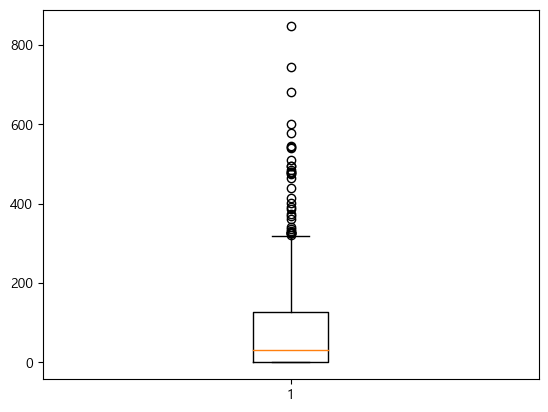

In [103]:
plt.boxplot(df.Insulin)
plt.show()

- 인슐린 수치를 boxplot으로 보면 , 이상치가 많은데 , 이 이상치는 당뇨에 밀접한 관련이 있어보인다. 상관관계를 보자.

<Axes: >

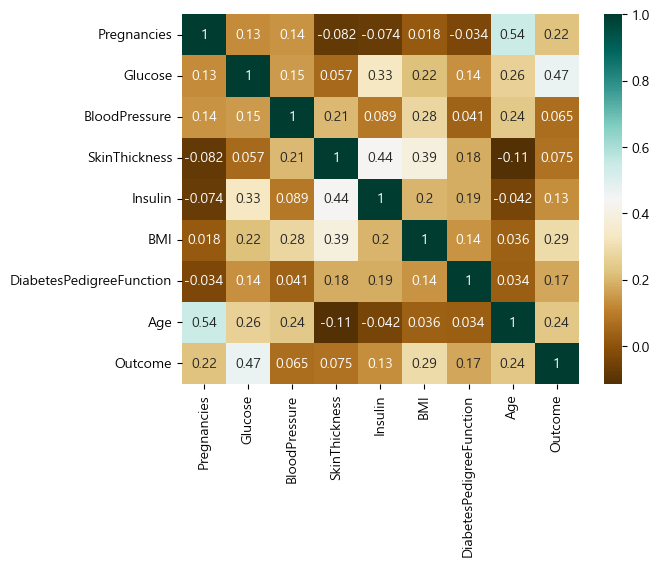

In [104]:
sns.heatmap(df.corr() , annot = True , cmap = 'BrBG')

- Outcome과 인슐린의 상관계수는 0.13으로 , 그닥 높지 않다. 그러면 이상치를 지우자

In [105]:
#이상치 인덱스를 확인하는 함수
def get_outlier(df = None , column = None , weight = 1.5):
    fraud = df[df['Outcome'] == 1][column]
    quantile_25 = np.percentile(fraud.values , 25)
    quantile_75 = np.percentile(fraud.values , 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

In [106]:
index_ = get_outlier(df = df , column = 'Insulin' , weight = 1.5)

In [107]:
df.drop(index_ , axis = 0 , inplace = True)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               756 non-null    int64  
 1   Glucose                   756 non-null    int64  
 2   BloodPressure             756 non-null    int64  
 3   SkinThickness             756 non-null    int64  
 4   Insulin                   756 non-null    int64  
 5   BMI                       756 non-null    float64
 6   DiabetesPedigreeFunction  756 non-null    float64
 7   Age                       756 non-null    int64  
 8   Outcome                   756 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 59.1 KB


- 이상치 12개가 제거되었다

In [109]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,756.0,3.849206,3.373604,0.000,1.000,3.0000,6.0000,17.00
Glucose,756.0,120.142857,31.560109,0.000,99.000,116.0000,139.0000,199.00
BloodPressure,756.0,69.064815,19.449777,0.000,63.500,72.0000,80.0000,122.00
SkinThickness,756.0,20.322751,15.941335,0.000,0.000,23.0000,32.0000,99.00
Insulin,756.0,72.461640,99.404811,0.000,0.000,18.0000,122.0000,744.00
BMI,756.0,31.948942,7.915590,0.000,27.200,32.0000,36.5250,67.10
DiabetesPedigreeFunction,756.0,0.469896,0.326644,0.078,0.244,0.3705,0.6245,2.42
Age,756.0,33.160053,11.691489,21.000,24.000,29.0000,40.0000,81.00
Outcome,756.0,0.338624,0.473555,0.000,0.000,0.0000,1.0000,1.00


In [110]:
df.mean(axis = 0)

Pregnancies                   3.849206
Glucose                     120.142857
BloodPressure                69.064815
SkinThickness                20.322751
Insulin                      72.461640
BMI                          31.948942
DiabetesPedigreeFunction      0.469896
Age                          33.160053
Outcome                       0.338624
dtype: float64

<BarContainer object of 9 artists>

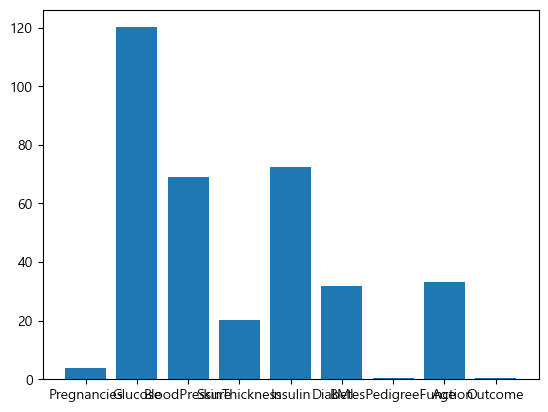

In [111]:
plt.bar(x = df.mean(axis = 0).index , height = df.mean(axis = 0))

- 수치들의 평균을 시각화했는데 , 제각각이다. 정규화하는 것이 좋겠다.

In [112]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [113]:
data = df.iloc[:,:-1]
target = df.iloc[:,-1]

In [114]:
data_scaled = ss.fit_transform(data)

In [115]:
target.value_counts()

0    500
1    256
Name: Outcome, dtype: int64

- 두배 차이 나니까 조절하자

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
train_input , test_input , train_target , test_target = train_test_split(data_scaled , target , test_size = 0.2 , random_state = 0 , stratify = target)

- knn , LogisticRegression , RandomForestClassifier , LGBMClassifier 4개 사용하자

**실제 당뇨병 환자중에 당뇨병이 아니라고 진단하면 심각하기 때문에 , 재현율(recall)에 초점을 두기** 

In [118]:
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
lgb = LGBMClassifier(random_state = 0)
kn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state = 0)
lr = LogisticRegression(random_state = 0)

In [119]:
model = [lgb,kn,rf,lr]
recall_ = []
precision_ = []
for i in model:
    print(i.__class__.__name__)
    print(model_fit(i , train_input , train_target))
    print()
    print()
    print()
    recall = recall_score(test_target , i.predict(test_input))
    precision = precision_score(test_target , i.predict(test_input))
    recall_.append(recall)
    precision_.append(precision)

LGBMClassifier
오차 행렬(혼동 행렬)
[[89 12]
 [19 32]]
정확도:0.7961, 정밀도:0.7273, 재현율:0.6275, F1:0.6737
None



KNeighborsClassifier
오차 행렬(혼동 행렬)
[[90 11]
 [21 30]]
정확도:0.7895, 정밀도:0.7317, 재현율:0.5882, F1:0.6522
None



RandomForestClassifier
오차 행렬(혼동 행렬)
[[91 10]
 [19 32]]
정확도:0.8092, 정밀도:0.7619, 재현율:0.6275, F1:0.6882
None



LogisticRegression
오차 행렬(혼동 행렬)
[[91 10]
 [20 31]]
정확도:0.8026, 정밀도:0.7561, 재현율:0.6078, F1:0.6739
None





In [120]:
np.mean(recall_)

0.6127450980392157

- 4개의 모델 재현율 평균은 0.61

## 오버샘플링

In [121]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 0)
train_input_over , train_target_over = smote.fit_resample(train_input , train_target)

In [122]:
recall__ = []
precision__ = []
for i in model:
    print(i.__class__.__name__)
    print(model_fit(i , train_input_over , train_target_over))
    print()
    print()
    print()
    recall = recall_score(test_target , i.predict(test_input))
    precision = precision_score(test_target , i.predict(test_input))
    recall__.append(recall)
    precision__.append(precision)

LGBMClassifier
오차 행렬(혼동 행렬)
[[87 14]
 [20 31]]
정확도:0.7763, 정밀도:0.6889, 재현율:0.6078, F1:0.6458
None



KNeighborsClassifier
오차 행렬(혼동 행렬)
[[80 21]
 [13 38]]
정확도:0.7763, 정밀도:0.6441, 재현율:0.7451, F1:0.6909
None



RandomForestClassifier
오차 행렬(혼동 행렬)
[[90 11]
 [20 31]]
정확도:0.7961, 정밀도:0.7381, 재현율:0.6078, F1:0.6667
None



LogisticRegression
오차 행렬(혼동 행렬)
[[82 19]
 [13 38]]
정확도:0.7895, 정밀도:0.6667, 재현율:0.7451, F1:0.7037
None





In [123]:
np.mean(recall__)

0.6764705882352942

- 재현율이 0.61에서 0.67로 올랐다

Text(0, 0.5, '정밀도')

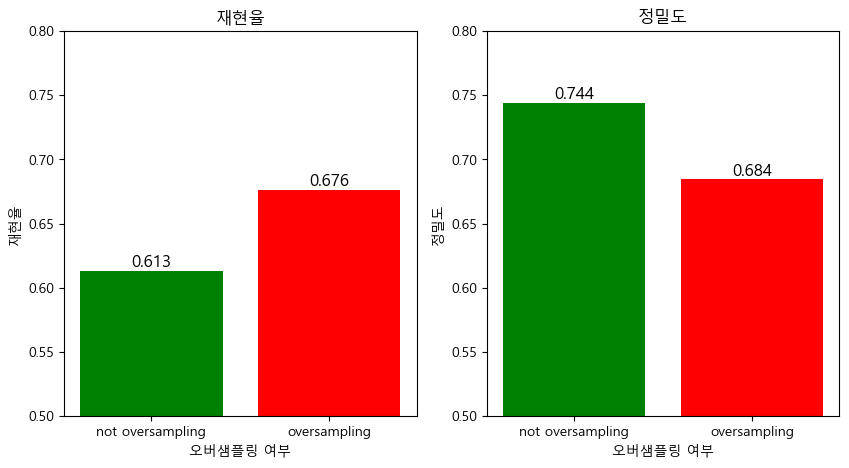

In [124]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
x = plt.bar(x = [1,2] , height = [np.mean(recall_) , np.mean(recall__)] , color = ['green','red'])
plt.xticks([1,2] , ['not oversampling' , 'oversampling'])

for i in x:
    height = round(i.get_height() , 3)
    plt.text(i.get_x()+i.get_width()/2.0,height,  height, ha = 'center',va='bottom',size=12)
    
plt.ylim(0.5,0.8)

plt.title('재현율')
plt.xlabel('오버샘플링 여부')
plt.ylabel('재현율')

plt.subplot(1,2,2)

y = plt.bar(x = [1,2] , height = [np.mean(precision_) , np.mean(precision__)] , color = ['green','red'])
plt.xticks([1,2] , ['not oversampling' , 'oversampling'])

for i in y:
    height = round(i.get_height() , 3)
    plt.text(i.get_x()+i.get_width()/2.0,height,  height, ha = 'center',va='bottom',size=12)
    
plt.ylim(0.5,0.8)

plt.title('정밀도')
plt.xlabel('오버샘플링 여부')
plt.ylabel('정밀도')


- 재현율은 올라갔지만 , 정밀도는 내려갔다.

**정밀도는 당뇨라 예측했을 때 당뇨가 아닌 것(FP)에 영향을 받고 재현율은 당뇨가 아니라 예측했는데 알고보니 당뇨인 것(FN)에 영향을 받으니 , 이 데이터에선 재현율이 낮으면 심각도가 더 높아진다고 할 수 있다**